# desc-wfmon/monexp.ipynb: Monitor explorer example

We use the classes in desc-wfmon to view monitoring data from DESC gen3 parsl jobs.

Typically, this file is copied to the area where the jobs were run.

First setup to use the local install area and then import the the system (sysmon) and process (wfmon) explorers. 

See desc-wfmon/install.ipynb to install that package in the local directory and create the setup on the first line. 

In [1]:
print('Notebook version is 6.1.dev1')
import sys
import os
import datetime
homedir = os.getenv('HOME')
print(f"Current directory is {os.getcwd()}")
stzone = datetime.datetime.utcnow().astimezone().tzinfo
print(f"Local time zone is {stzone}")
srcdir = f"{homedir}/desc/dev"
nbdir = srcdir + '/desc-wfmon/ipynb'
%run $nbdir/setup.ipynb
print('Checking for local install of desc-wfmon')
%run install/setup.py
print(f"Python version is {sys.version}")
print(f"Python search path starts with {sys.path[0]}:{sys.path[1]}:{sys.path[2]}")
!pwd
import pandas
import numpy
import matplotlib.pyplot as plt
import matplotlib.colors as pltcol
import desc.wfmon
import desc.sysmon
for pkg in [desc.wfmon, desc.sysmon]:
    print(f"{pkg} version is {pkg.__version__}")


Notebook version is 6.1.dev1
Current directory is /Users/davidadams/xfer/2022/0621/ptest60-wq-pmcp-cvmfs-001
Local time zone is EDT
LPO-168646.local:/Users/davidadams/xfer/2022/0621/ptest60-wq-pmcp-cvmfs-001: Thu Jun 23 13:50:34 EDT 2022
Setting up desc-wfmon
Installing up desc-wfmon
bootstrap: Installing descr-wfmon.
Installing /Users/davidadams/desc/dev/desc-wfmon at ./install/noconda
Processing /Users/davidadams/desc/dev/desc-wfmon
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for desc-wfmon: filename=desc_wfmon-0.11.1-py3-none-any.whl size=28004 sha256=054e61ea5d5b73aa5c7307fa5fe8d7c56e2b388d0f73d68c593425fd80c0a946
  Stored in directory: /Users/davidadams/Library/Caches/pip/wheels/c9/7d

## Configuration
Define some useful constants and specify the location of the monitoring data files. Set dir to point to your area.

In [2]:
# Read the config.
%run monexp.py

# Defaults for configuration.
class monexp_def:
    dir = os.getcwd()
    name = os.path.basename(os.getcwd())
    stunit = 'minute'         # Unit for time axes
    sbunit = 'gb'             # Unit for memory, I/O
    tmin = 0                  # Min time for time axes
    tmax = 20                 # Max time for time axes
    taskrunmax = 130          # Max for running task axes
    tasktimemax = 200         # Max for time/task axis [s]
    taskcount_interval = 10   # Sampling interval for evaluating try task counts
    tzoff = 0                 # Time zone offset between system and process monitors
    tlatencymax = 20          # Max for latency axis
    tlatrunmax = 100          # Max for lataency + run time
    iosummax = 1000           # Max for the integrated I/O plot [GB]
    
# Set defaults for any missing parameters.
if 'monexp' not in dir():
    monexp = monexp_def
else:
    for nam in monexp_def.__dict__:
        if nam[0:2] == '__': continue
        if not hasattr(monexp, nam):
            setattr(monexp, nam, getattr(monexp_def, nam))
        
# Time conversions and plotting units.
tunits = {'second':1, 'minute':60, 'hour':3600, 'day':24*3600}
stunit = monexp.stunit
tunit = tunits[stunit]

# Memory and I/O conversion plotting units.
bunits = {'mb':2**20, 'gb':2**30}
gb = bunits['gb']
sbunit = monexp.sbunit
bunit = bunits[sbunit]
bunit_sys = bunit/gb

# Time range for the plots
# if tmax <= tmin, it will be reset with the data below
tmin = monexp.tmin
tmax = monexp.tmax

print(f"Time zone offset: {monexp.tzoff} sec")

# Plot size
pdx = 20
pdy = 6

line = '-----------------------------------------------------------'
fread = monexp.dir + '/README.txt'
if os.path.exists(fread):
    fin = open(fread, 'r')
    #readme = fin.read().strip()
    readme = fin.readlines()
    with open(fread) as fin:
        readme = [line.rstrip() for line in fin]
else:
    raise Exception('README.txt not found')
print('README:')
for line in readme: print(line)
pttl = monexp.name + ": " + readme[0]
print(f"Plot title: {pttl}")
pfx = monexp.name
print(f"Plot file prefix: {pfx}")
sfx = '.png'
print(f"Plot file suffix: {sfx}")
plt.rc('font', size=16)
plt.rc('savefig', facecolor='white', bbox='tight')
plt.rc('axes', titlesize='medium')

pandas.options.display.width = 150

Time zone offset: 10800 sec
README:
14Jun2022 Parsltest on nid005815 with 5000 (20 sec, 10 GB) tasks, WorkQueue with 100 workers, 5 sec sampling

ptest60-wq-pmcp-cvmfs-001
Plot title: ptest60-wq-pmcp-cvmfs-001: 14Jun2022 Parsltest on nid005815 with 5000 (20 sec, 10 GB) tasks, WorkQueue with 100 workers, 5 sec sampling
Plot file prefix: ptest60-wq-pmcp-cvmfs-001
Plot file suffix: .png


## Fetch system-level monitoring data

System level monitoring data is collected using *desc.sysmon*. The data is in csv format and is read here with *pandas*.

The column names follow from those of the corresponding *psutil* variables.

We fetch the number of CPUs and total memory and check both are consistent for all samples.

In [3]:
sym = pandas.read_csv(monexp.dir + '/sysmon.csv')
print(f"System monitor sample count: {len(sym)}")
print(f"System monitor columns:")
for cnam in sym.columns:
    print(f"  {cnam}")

assert(len(sym.cpu_count.unique()) == 1)
ncpu = sym.cpu_count[0]
print(f"CPU count is {ncpu:.0f}")

assert(len(sym.mem_total.unique()) == 1)
maxmem = sym.mem_total[0]/bunit_sys
print(f"Total memory is {maxmem:.1f} {sbunit}")


System monitor sample count: 260
System monitor columns:
  time
  cpu_count
  cpu_percent
  cpu_freq
  cpu_user
  cpu_system
  cpu_idle
  cpu_iowait
  cpu_time
  mem_total
  mem_available
  mem_swapfree
  dio_readsize
  dio_writesize
  nio_readsize
  nio_writesize
CPU count is 256
Total memory is 503.2 gb


## Fetch the process-level monitoring data

The process monitoring data is read from the mysql DB produced by parsl. Of particular interest is the task table where metrics are sampled at regular intervals seprately for each job.

We "fix" that data to make it more amenable for analysis. Among many other modifications, fixing converts time strings to integers and add a procsum (process summary) table which sums the contributions from all jobs. Although the sampling interval is the same for all jobs, they have different offsets and so there is some ambiguity in this summing.

For disk and network I/O, integrated values are recorded but the differential values (the amount read or written each sampling interval) are of interest here. A separate call is made to build a procsum table that includes these differential values. This is not done automatically because it can be slow.

In [4]:
for subdir in ['', '/runinfo']:
    fnam = f"{monexp.dir}{subdir}/monitoring.db"
    if os.path.exists(fnam):
        dbr = desc.wfmon.MonDbReader(fnam, dodelta=True)
print(f"Label: {pttl}")
dbr.tables(2)

Label: ptest60-wq-pmcp-cvmfs-001: 14Jun2022 Parsltest on nid005815 with 5000 (20 sec, 10 GB) tasks, WorkQueue with 100 workers, 5 sec sampling
DB /Users/davidadams/xfer/2022/0621/ptest60-wq-pmcp-cvmfs-001/runinfo/monitoring.db has 9 tables
*******************************************************
Table workflow has 1 rows and 9 columns
Column names:
     int64   run_idx
     int64   wf_idx
   float64   time_began
   float64   time_completed
    object   host
    object   user
    object   rundir
     int64   tasks_failed_count
     int64   tasks_completed_count
*******************************************************
Table task has 5000 rows and 15 columns
Column names:
     int64   task_id
     int64   run_idx
    object   task_depends
     int64   task_idx
    object   task_memoize
    object   task_hashsum
    object   task_inputs
    object   task_outputs
    object   task_stdin
    object   task_stdout
    object   task_stderr
   float64   task_time_invoked
   float64   task_time_ret

## Run selection
Define handles for the process tables of interest:

* wkf - Workflow table with one entry for each run
* tsk - Task table holds a description of each task
* tst - Try table has entry each time a task is run or rerun
* prc - Process table holds sampled data for each process
* psm - Procsum (process summary) table holds samples summed over all processes

If the process monitor includes more than one run, then select one run to study here.

In [5]:
nrun = len(dbr.table('workflow'))
if nrun == 1:
    print('One run found.')
    wkf = dbr.table('workflow')
    tsk = dbr.table('task')
    tst = dbr.table('try')
    prc = dbr.table('resource')
    psm = dbr.table('procsum')
else:
    rqry = 'run_idx==0'
    print(f"Selecting runs with {rqry}")
    wkf = dbr.table('workflow').query(rqry)
    tsk = dbr.table('task').query(rqry)
    tst = dbr.table('try').query(rqry)
    prc = dbr.table('resource').query(rqry)
    psm = dbr.table('procsum').query(rqry)
print(f"Process table entry count: {len(prc)}")
print(f"Procsum table entry count: {len(psm)}")
print(f" System table entry count: {len(sym)}")
have_procsum = len(psm) > 0

One run found.
Process table entry count: 28861
Procsum table entry count: 257
 System table entry count: 260


## Time range

For convenience we add a column tfix to each table that converts to units defined above. The try table includes three state timees:
* launched - The task is made ready to run
* running - The CPU process starts.
* returned - The CPU process terminates.  

The time offset used in the process tables is applied to the system table. A configureable offset is also added, e.g. to account for time zone issues.

In [6]:
t0sec = dbr.t0 + monexp.tzoff
delt = dbr.monitoring_interval
if delt is None : delt = 0.0
deltfix = delt/tunit
deltsys = (max(sym.time) - min(sym.time))/float(len(sym) - 1)

wkf['tfix_began'] = wkf.time_began/tunit
wkf['tfix_completed'] = wkf.time_completed/tunit
tst['trun'] = tst.task_try_time_returned - tst.task_try_time_running
tst['tfix_launched'] = tst.task_try_time_launched/tunit
tst['tfix_running'] = tst.task_try_time_running/tunit
tst['tfix_returned'] = tst.task_try_time_returned/tunit
tsk['tfix_invoked'] = tsk.task_time_invoked/tunit
prc['tfix'] = prc.timestamp/tunit
if have_procsum:
    psm['tfix'] = psm.timestamp/tunit
    psm_tfix = psm['tfix']
    psm_interval_tfix = pandas.concat([pandas.Series([(psm_tfix[0]-deltfix)]), psm_tfix])
sym['tfix'] = (sym.time - t0sec)/tunit

twkf1 = wkf.tfix_began.min()
twkf2 = wkf.tfix_completed.max()
tlau1 = tst.tfix_launched.min()
tlau2 = tst.tfix_launched.max()
tinv1 = tsk.tfix_invoked.min()
tinv2 = tsk.tfix_invoked.max()
tprc1 = prc.tfix.min()
tprc2 = prc.tfix.max()
if have_procsum:
    tpsm1 = psm.tfix.min()
    tpsm2 = psm.tfix.max()
tsym1 = sym.tfix.min()
tsym2 = sym.tfix.max()
if tmax <= tmin:
    tmax = 1.01*tprc2

print(f"  Proc time interval: {delt:.2f} sec")
print(f"   Sys time interval: {deltsys:.2f} sec")
print(f" Workflow time range: ({twkf1:.2f}, {twkf2:.2f}) {stunit}")
print(f"   Invoke time range: ({tinv1:.2f}, {tinv2:.2f}) {stunit}")
print(f"   Launch time range: ({tlau1:.2f}, {tlau2:.2f}) {stunit}")
print(f"  Process time range: ({tprc1:.2f}, {tprc2:.2f}) {stunit}")
if have_procsum:
    print(f"  Procsum time range: ({tpsm1:.2f}, {tpsm2:.2f}) {stunit}")
print(f"   System time range: ({tsym1:.2f}, {tsym2:.2f}) {stunit}")
print(f" Plotting time range: ({ tmin:.2f}, { tmax:.2f}) {stunit}")

  Proc time interval: 5.00 sec
   Sys time interval: 5.05 sec
 Workflow time range: (0.00, 22.84) minute
   Invoke time range: (0.00, 1.47) minute
   Launch time range: (0.00, 1.47) minute
  Process time range: (0.05, 21.47) minute
  Procsum time range: (0.04, 21.38) minute
   System time range: (-0.00, 21.82) minute
 Plotting time range: (0.00, 30.00) minute


## Tasks
We look at the task types, how many of each were run and plot the distribution of run times for the tasks.

         Task idx count: 1
             Task count: 5000
      Unique task count: 5000
              Try count: 5000
         Try done count: 5000
  Max task by tid count: 5000

Task name [done/count]
   0: mybash_ifix [5000/5000/5000] 21.7


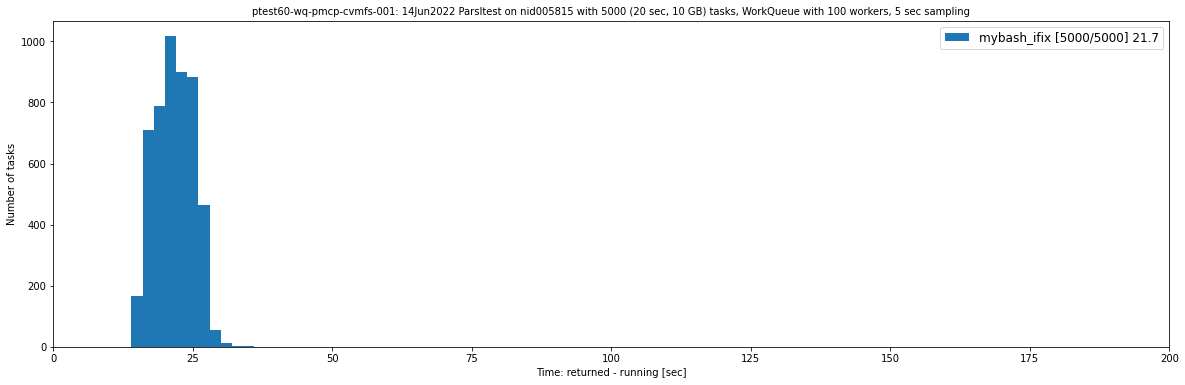

In [7]:
tsk = dbr.table('task')
tsy = dbr.table('try')
ntsk = len(tsk)
ntid = len(tsk.task_idx.unique())
ntry = len(tsy)
trunMax = (tsy.task_try_time_running - tsy.task_try_time_launched).dropna().max()
tsyDone = tsy.query("task_try_time_returned==task_try_time_returned")
ntryDone = len(tsyDone)
ntskByTid = []
for itid in range(ntid):
    ntskByTid.append(len(tsk.query(f"task_idx=={itid}")))
ntskByTidMax = max(ntskByTid)
print(f"         Task idx count: {ntid}")
print(f"             Task count: {ntsk}")
print(f"      Unique task count: {len(tsk.task_id.unique())}")
print(f"              Try count: {ntry}")
print(f"         Try done count: {ntryDone}")
print(f"  Max task by tid count: {ntskByTidMax}")

print()
print("Task name [done/count]")
assert(ntid == len(dbr.task_names))
tsyDoneByTask = [None]*ntid
for itid in range(ntid):
    tsyDoneByTask[itid] = tsyDone.query(f"task_idx=={itid}")
    t1 = tsyDoneByTask[itid].task_try_time_running
    t2 = tsyDoneByTask[itid].task_try_time_returned
    nrun = t1.count()
    ndone = t2.count()      # count ignores NaN
    if nrun != ndone:
        savg = f"ERROR: nrun={nrun} != ndone={ndone}"
    elif len(t2):
        avg = (t2-t1).mean()
        savg = f" {avg:.1f}"
    else:
        savg = ''
    print(f"{itid:4}: {dbr.task_names[itid]} [{ndone}/{nrun}/{dbr.task_name_counts[itid]}]{savg}")


x1 = 0
x2 = monexp.tasktimemax
# Fetch run times for each type of task
taskdts = [None]*ntid
cols = [None]*max(ntid,3)
ncol = len(cols)
labs = [None]*ntid
#mycols = ['red', 'green', 'orange', 'blue', 'yellow', 'violet', 'cyan', 'pink']
for itid in range(ntid):
    t1 = tsyDoneByTask[itid].task_try_time_running
    t2 = tsyDoneByTask[itid].task_try_time_returned
    if len(t2):
        avg = (t2-t1).mean()
        savg = f" {avg:.1f}"
    else:
        savg = ''
    taskdts[itid] = (t2-t1).clip(upper=0.999*x2)
    #cols[itid] = 'tab:' + mycols[itid%8]
    labs[itid] = f"{dbr.task_names[itid][0:20]} [{len(tsyDoneByTask[itid])}/{dbr.task_name_counts[itid]}]{savg}"
    #print(f"Color {cols[itid]}")
plt.figure(figsize=(pdx, pdy))
plt.hist(bins=100, range=(x1, x2), x=taskdts, stacked=True, label=labs)
plt.legend(loc="upper right", fontsize=12)
plt.xlabel('Time: returned - running [sec]')
plt.ylabel('Number of tasks')
junk = plt.xlim([x1, x2])
plt.title(pttl)
plt.savefig(pfx+'ttask'+sfx)

## Throughput

The *taskcounts* method uses the task state times from the try table to evaluate the integrated number of tasks that have reached each of the task states
(launched, running, returned) as a function of time.

If there is more than one task type, we plot this for the running and returned states with a separate curve for each type.

In [8]:
if tprc2 > 0.8*tmax:
    legloc = "upper left"
else:
    legloc = "upper right"
print(f"Task count interval: {monexp.taskcount_interval}")
dbr.taskcounts(delt=monexp.taskcount_interval)
for dfs in dbr._taskcounts:
    for idf in dfs:
        dfs[idf]['tfix'] = dfs[idf].time/tunit
dbr._taskcounts[0]['running']
#print(dbr.taskcounts('returned', 0))
state = 'running'
tsclau = dbr.taskcounts('launched')
tscrun = dbr.taskcounts('running')
tscret = dbr.taskcounts('returned')
tscact = tscrun - tscret   # Number of task running
tscmax = tscret.tfix.max()
#print(f"Run time is {tscmax:.1f} {stunit}")
if ntid > 1:
    for sstat in ['running', 'returned']:
        plt.figure(figsize=(pdx, pdy))
        tsc = dbr.taskcounts(sstat)
        for itid in range(ntid):
            plt.plot(tsc.tfix, tsc[itid], '.', color=cols[itid%ncol], label=labs[itid])
        plt.xlabel(f"Time [{stunit}]")
        plt.ylabel(f"Integrated {sstat} task count")
        plt.legend(loc=legloc, fontsize=10)
        plt.grid(True)
        junk = plt.axis([tmin, tmax, 0, 1.02*ntskByTidMax])
        plt.title(pttl)
        plt.savefig(f"{pfx}sn{sstat[0:3]}{sfx}")
        plt.show()

Task count interval: 1


## Throughput

This figure shows the total number of jobs launched, started and finished as function of time.
The time at which the last task completes is the time for the run (workflow) and is shown on the plot.

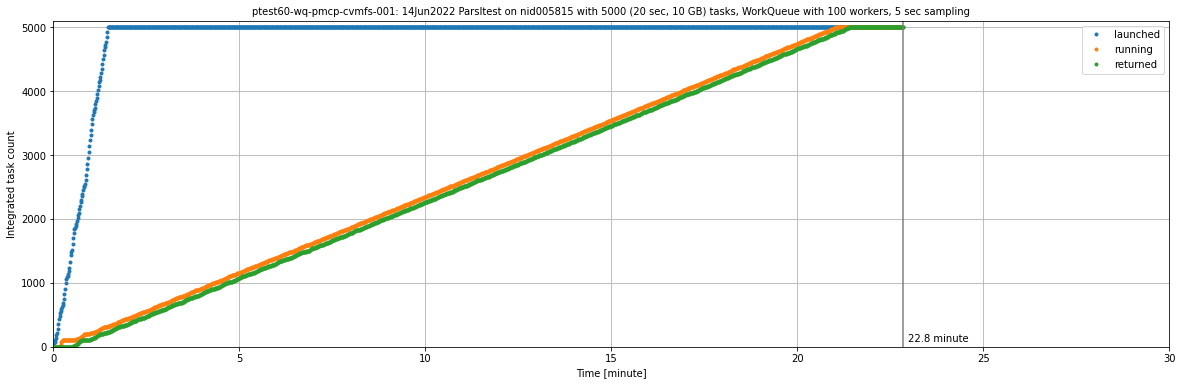

In [9]:
plt.figure(figsize=(pdx, pdy))
plt.plot(tscrun.tfix, tsclau['all'], '.', color=cols[0], label='launched')
plt.plot(tscrun.tfix, tscrun['all'], '.', color=cols[1], label='running')
plt.plot(tscrun.tfix, tscret['all'], '.', color=cols[2], label='returned')
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Integrated task count')
plt.legend(loc=legloc)
plt.grid(True)
ymin = 0.0
ymax = 1.02*ntsk
junk = plt.axis([tmin, tmax, ymin, ymax])
if ntryDone == ntry and tscmax <= tmax:
    wx = tmax - tmin
    wy = ymax - ymin
    if tscmax > 0.8*tmax:
        ha = 'right'
        dx = -0.005*wx
    else:
        ha = 'left'
        dx = 0.005*wx
    plt.plot([tscmax, tscmax], [ymin, ymax], color='gray', linestyle='-')
    plt.text(tscmax + dx, ymin + 0.015*wy, f"{tscmax:.1f} {stunit}", ha=ha)
plt.title(pttl)
plt.savefig(pfx+'throughput'+sfx)

## Running task count

The difference between the integrated running and returned task counts provides the number of active tasks as a function of time.
Separates curves are plotted here for each task type and for all combined.

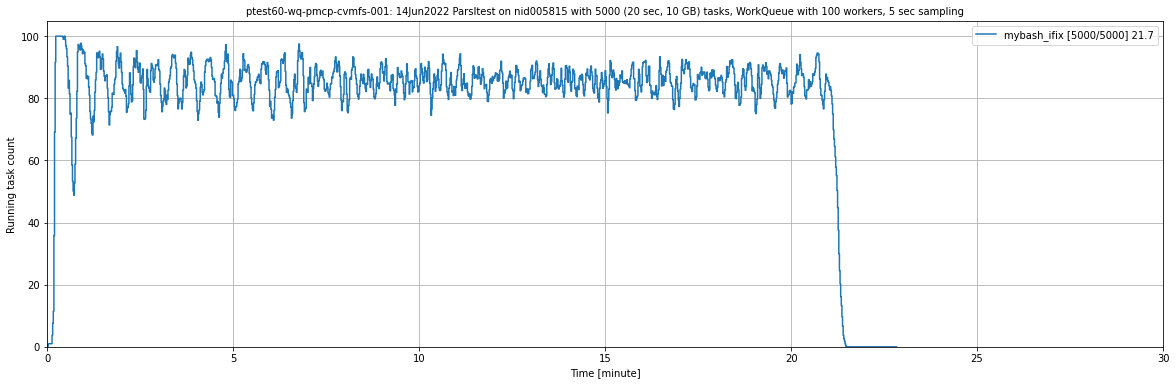

In [10]:
xmin = tmin
xmax = tmax
ymin = 0
ymax = monexp.taskrunmax
plt.figure(figsize=(pdx, pdy))
tscact = (tscrun['all'] - tscret['all'])
if ntid > 1: plt.step(x=tscrun.tfix, y=tscact, color='black', label='all')
for itid in range(ntid):
    ytmp = tscrun[itid] - tscret[itid]
    plt.step(x=tscret.tfix, y=ytmp, color=cols[itid%ncol], label=labs[itid])
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Running task count')
plt.legend(fontsize=10)
plt.title(pttl)
#plt.setp(plt.gca().get_legend().get_texts(), fontsize='8')
plt.grid(True)
junk = plt.axis([xmin, xmax, ymin, ymax])
plt.title(pttl)
plt.savefig(pfx+'nruntask'+sfx)

## Procsum estimate of running task count

The preceding estimate of running task count is based on the recorded process start and stop times and so can be evaluated precisely at a very fine time granularity.
The running task count can also be estimated from the procsum table but the time resolution is limited by the resource sampling frequency.
The two are overlaid in the following plot.
This is an important check because the following procsum estimates of utilization and I/O (which cannot be obtained otherwise) have the same limitations.

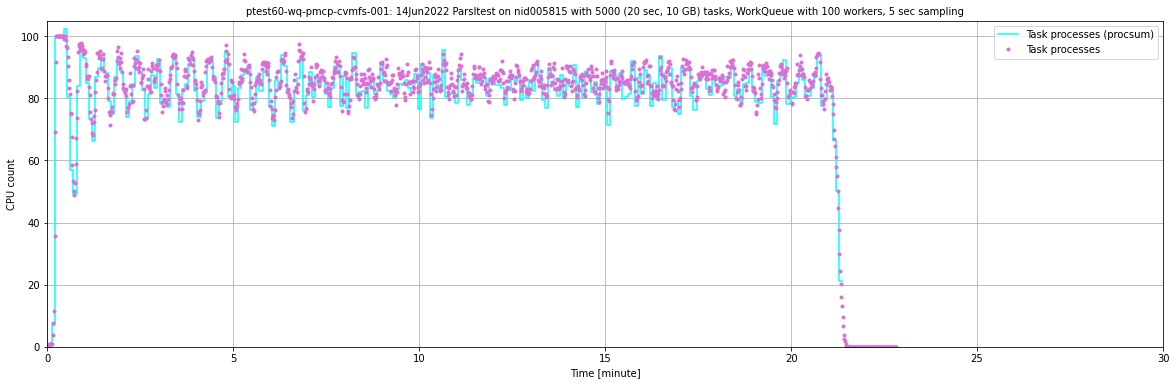

In [11]:
if have_procsum:
    xmin = tmin
    xmax = tmax
    #xmin = 4
    #xmax = 8
    plt.figure(figsize=(pdx, pdy))
    psmproc = psm.procsum_time_clock/delt
    #plt.step(x=tscrun.tfix, y=tscact, color='black', label='all')
    plt.step(x=psm_tfix, y=psmproc, where='pre', color='cyan', label='Task processes (procsum)')
    plt.plot(tscrun.tfix, tscact, '.', color='orchid', label='Task processes')
    plt.xlabel(f"Time [{stunit}]")
    plt.ylabel('CPU count')
    plt.grid(True)
    plt.legend()
    junk = plt.axis([xmin, xmax, ymin, ymax])
    plt.title(pttl)
    plt.savefig(pfx+'proccount'+sfx)

## CPU utilization

The CPU utilization is the fraction of time each "CPU" is working, i.e. not in the idle state. The system monitor gets this direcly from *psutil.cpy_percent* which return a value averaged over time since the last sampling and averaged over all hyperthreads.
We obtain an estimate for running task processes by summing the times each process specnds in the user and system states and the dviding by the sampling time and total number of available hyperthreads.

The following plot shows these two values as a function of time.
We expect the system values to be larger because they include CPU used by the workflow and monitoring systems.

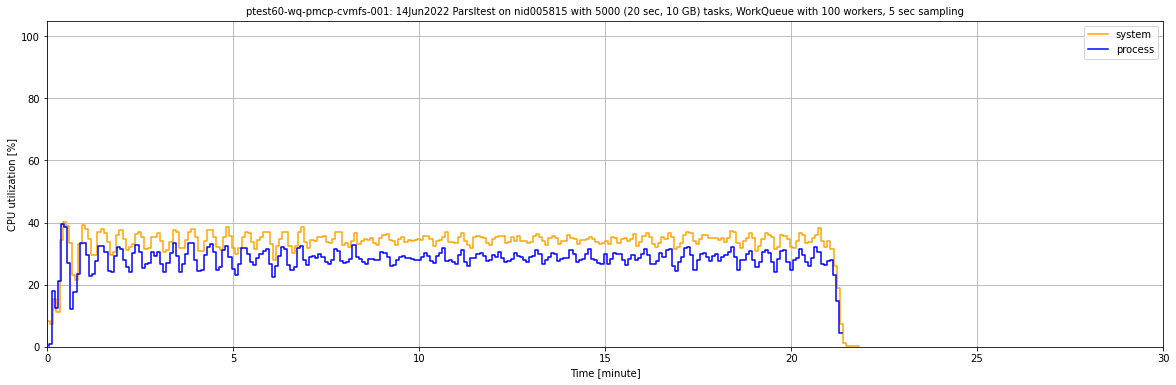

In [12]:
xmin = tmin
xmax = tmax
ymin = 0
ymax = 105
plt.figure(figsize=(pdx, pdy))
plt.step(x=sym.tfix, y=sym.cpu_percent, where='pre', color='orange', label='system')
# To get a process estimate, we divide the total user+sys time by the time interval and number of CPU.
if have_procsum:
    peff = 100*(psm.procsum_time_user+psm.procsum_time_system)/delt/ncpu
    plt.step(x=psm.tfix, y=peff, color='blue', label='process')
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('CPU utilization [%]')
plt.grid(True)
plt.legend()
junk = plt.axis([xmin, xmax, ymin, ymax])
plt.title(pttl)
plt.savefig(pfx+'cpueff'+sfx)

## Task count and utilization
Here we overlay the running task count with the total task utilization now normalized to the number of CPUs (hyperthreads).
For perlmutter, that number is 256.

Process count=1371, sum=108254.74080944061
Utilization count: 257


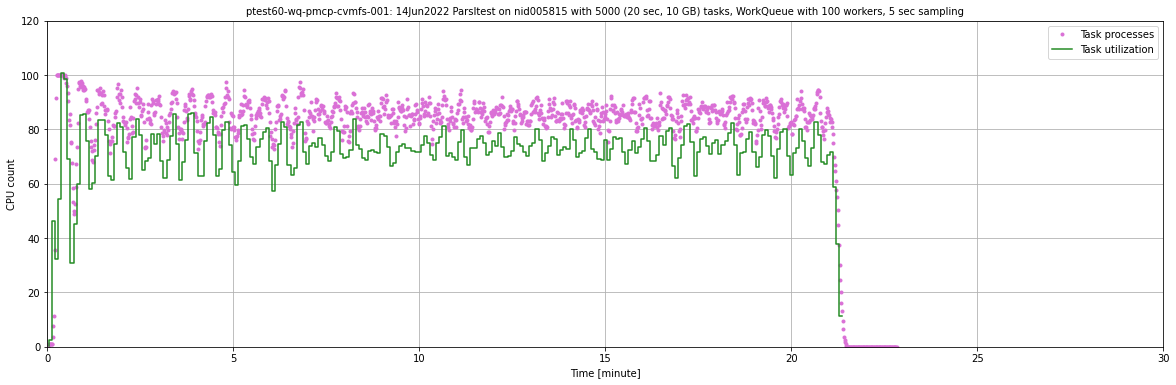

In [13]:
xmin = tmin
xmax = tmax
ymin = 0
ymax = 120
show_sysutil = False
show_psmprocs = False
plt.figure(figsize=(pdx, pdy))
if show_sysutil:
    scpu = sym.cpu_percent*ncpu*0.01
    plt.step(x=sym.tfix, y=scpu, where='pre', color='orange', linestyle='-', label='System utilization')
if have_procsum and show_psmprocs:
        psmproc = psm.procsum_time_clock/delt
        plt.step(x=psm_tfix, y=psmproc, where='pre', color='cyan', label='Task processes (procsum)')
plt.plot(tscrun.tfix, tscact, '.', color='orchid', label='Task processes')
print(f"Process count={len(tscact)}, sum={tscact.sum()}")
if have_procsum:
    # To get a process estimate, we divide the total user+sys time by the time interval and number of CPU.
    puse = (psm.procsum_time_user+psm.procsum_time_system)/delt
    plt.step(x=psm_tfix, y=puse, where='pre', color='forestgreen', marker='', linestyle='-', label='Task utilization')
    print(f"Utilization count: {len(puse)}")
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('CPU count')
plt.grid(True)
plt.legend()
junk = plt.axis([xmin, xmax, ymin, ymax])
plt.title(pttl)
plt.savefig(pfx+'cpucount'+sfx)

## Memory usage

The following plot shows the total memory used by the system and that used by running tasks.
The former is obtained from the system monitor and the latter from procsum.


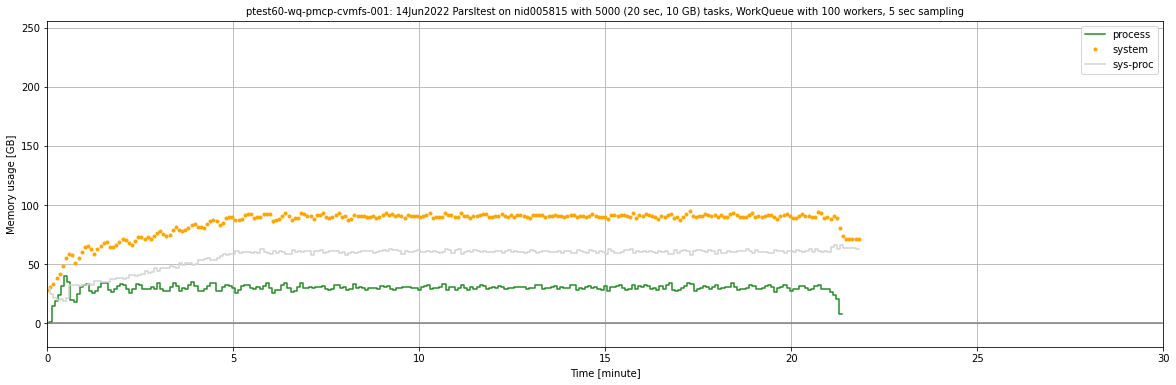

In [14]:
# First build psm2 which holds values with the same times as sym soe
# we can look at the difference between the two.
newidx = sym.tfix
if have_procsum:
    psm2 = psm[['tfix', 'procsum_memory_resident']].set_index('tfix', drop=False)
    psm2 = psm2.reindex(psm2.index.union(newidx))
    psm2.interpolate('index', inplace=True)
    psm2 = psm2.reindex(index=sym.tfix)
    psm2['tfix'] = psm2.index
    psm2 = psm2.set_index(sym.index)
# Now make the figure
plt.figure(figsize=(pdx, pdy))
ymin = -20
ymax = 256
xmin = tmin
xmax = tmax
smemtot = (sym.mem_total/bunit_sys).clip(lower=ymin, upper=ymax)
smem = ((sym.mem_total - sym.mem_available)/bunit_sys).clip(lower=ymin, upper=ymax)
if have_procsum:
    pmem = psm.procsum_memory_resident/gb
    pmem2 = psm2.procsum_memory_resident/gb
    diff = smem - pmem2
    
    #print(f"Check sizes: {len(smem)} == {len(pmem2)} == {len(diff)}")
    #print(type(smem), type(pmem2))
if have_procsum:
    plt.step(x=psm.tfix, y=pmem, where='pre', color='forestgreen', label='process')
    #plt.plot(psm.tfix, pmem, 'g.', label='process')
plt.plot(sym.tfix, smem, '.', color='orange', label='system')
if have_procsum:
    plt.step(x=psm2.tfix, y=diff, where='pre', color='lightgray', label='sys-proc')
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Memory usage [GB]')
plt.legend()
plt.grid(True)
if ymin*ymax < 0.0:
    plt.plot([xmin, xmax], [0,0], '-', color='gray')
junk = plt.axis([xmin, xmax, ymin, ymax])
plt.title(pttl)
plt.savefig(pfx+'mem'+sfx)

## I/O rates

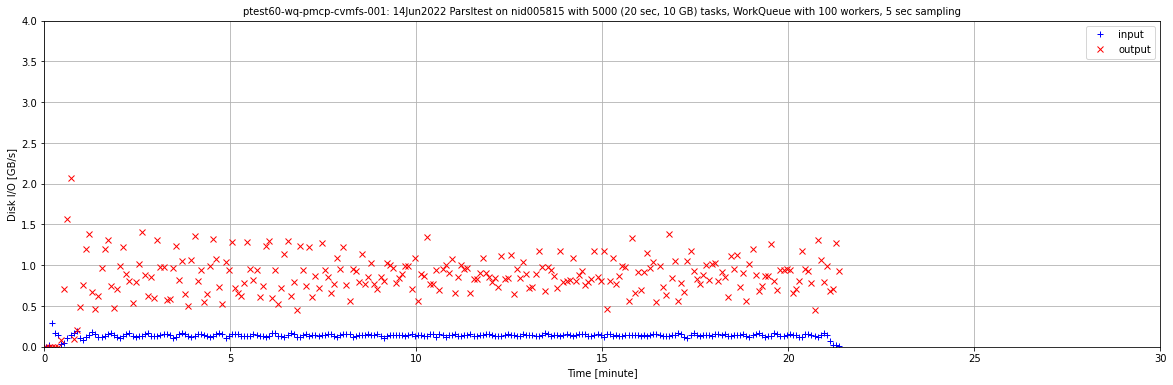

In [15]:
if have_procsum:
    plt.figure(figsize=(pdx, pdy))
    plt.plot(psm.tfix, psm.procsum_disk_read/gb/delt, 'b+', label='input')
    plt.plot(psm.tfix, psm.procsum_disk_write/gb/delt, 'rx', label='output')
    plt.xlabel(f"Time [{stunit}]")
    plt.ylabel('Disk I/O [GB/s]')
    plt.grid(True)
    plt.legend(loc="upper right")
    junk = plt.axis([tmin, tmax, 0, 4])
    plt.title(pttl)
    plt.savefig(pfx+'io'+sfx)
    plt.show()

(0.0, 30.0, 0.0, 1200.0)


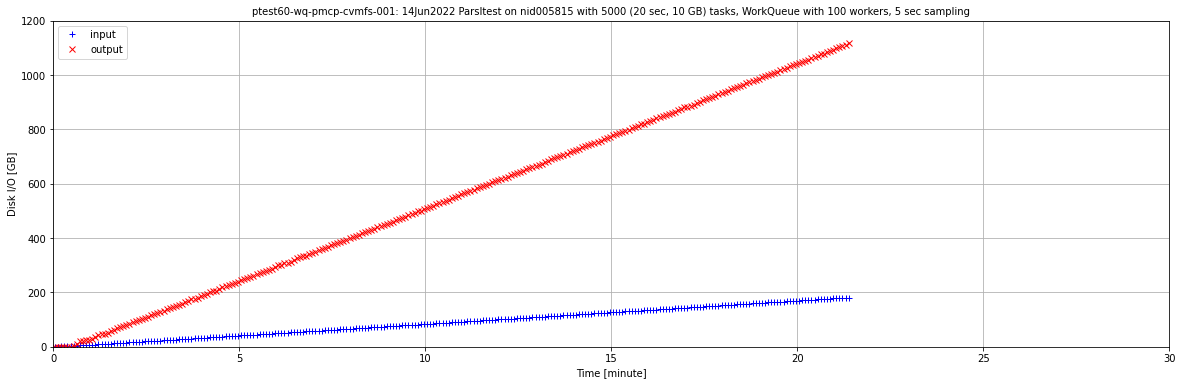

In [16]:
if have_procsum:
    xmin = tmin
    xmax = tmax
    ymin = 0.0
    ymax = monexp.iosummax
    plt.figure(figsize=(pdx, pdy))
    plt.plot(psm.tfix, psm.procsum_disk_read.cumsum()/gb, 'b+', label='input')
    plt.plot(psm.tfix, psm.procsum_disk_write.cumsum()/gb, 'rx', label='output')
    plt.xlabel(f"Time [{stunit}]")
    plt.ylabel('Disk I/O [GB]')
    plt.grid(True)
    plt.legend(loc="upper left")
    junk = plt.axis([xmin, xmax, ymin, ymax])
    print(junk)
    plt.title(pttl)
    plt.savefig(pfx+'io2'+sfx)
    plt.show()
    #print(plt.rcParams)

## Latency
Task submission latency is evaluated by assigning tasks to chains and defining the latency as the time between the end of one task and start of the next in a chain.
This latency estimate is suspect if the executor runs a variable number of workers.
For a fixed value, there is one chain per worker.

  Total chain count: 100
   Late chain count: 0
       Mean latency: 3.58 sec


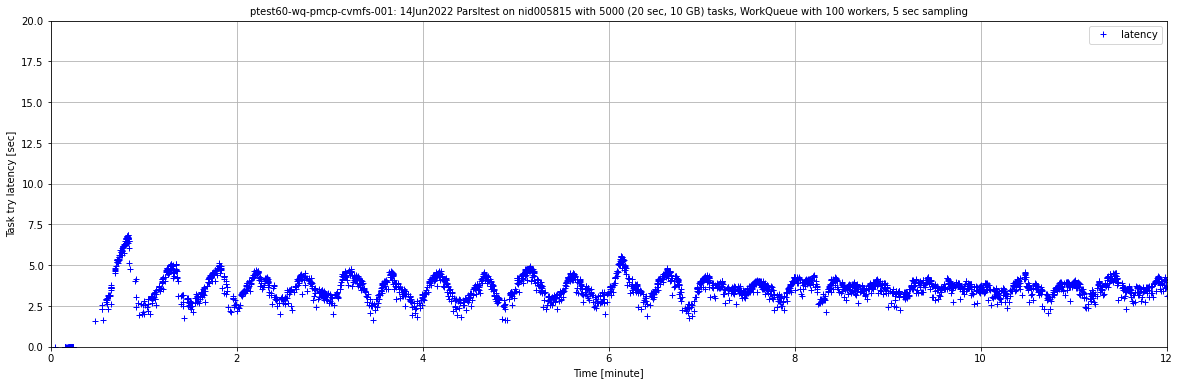

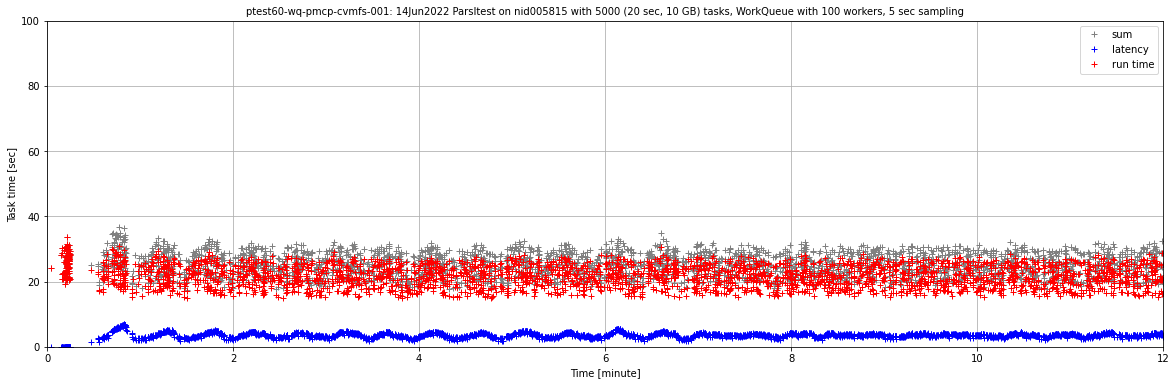

In [25]:
dbr.chaintasks()
print(f"  Total chain count: {dbr.taskchain_count('all')}")
print(f"   Late chain count: {dbr.taskchain_count('late')}")
print(f"       Mean latency: {tst.latency.mean():.2f} sec")
if dbr.taskchain_count():
    xmin = tmin
    xmax = tmax*0.4
    ymin = 0
    ymax = monexp.tlatencymax
    tsklat = tst.latency.clip(0,0.995*ymax)
    plt.figure(figsize=(pdx, pdy))
    plt.plot(tst.tfix_running, tsklat, 'b+', label='latency')
    plt.xlabel(f"Time [{stunit}]")
    plt.ylabel('Task try latency [sec]')
    plt.grid(True)
    plt.legend(loc="upper right")
    junk = plt.axis([xmin, xmax, ymin, ymax])
    plt.title(pttl)
    plt.savefig(pfx+'latency_vs_time'+sfx)
    plt.show()
    # Latency and run time
    ymin = 0
    ymax = monexp.tlatrunmax
    tsklat = tst.latency.clip(0,0.995*ymax)
    tskrun = tst['trun'].clip(0,0.995*ymax)
    tsksum = (tst.latency+tst.trun).clip(0,0.995*ymax)
    plt.figure(figsize=(pdx, pdy))
    plt.plot(tst.tfix_running, tsksum, color='gray', marker='+', linestyle='None', label='sum')
    plt.plot(tst.tfix_running, tsklat, 'b+', label='latency')
    plt.plot(tst.tfix_running, tskrun, 'r+', label='run time')
    plt.xlabel(f"Time [{stunit}]")
    plt.ylabel('Task time [sec]')
    plt.grid(True)
    plt.legend(loc="upper right")
    junk = plt.axis([xmin, xmax, ymin, ymax])
    plt.title(pttl)
    plt.savefig(pfx+'latrun_vs_time'+sfx)
    plt.show()